In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, './analogies_mining')
from tqdm.auto import tqdm
import torch
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from functools import partial

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from utils.models import Promptriever, get_model_general
from utils.predict import predict_labels, predict_labels_FollowIR, predict_labels_Promptriever
from utils.eval import evaluate_ranking
from utils.data import *
import pandas as pd
models_dict = {}


/home/dijkstraz/anaconda3/envs/colab/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [22]:
import os
import pandas as pd
import json

# Desired column order
column_order = [
    "None",  # Query
    "keyword", "keyphrase", "summary",
    "query + keyword", "query + keyphrase", "query + summary"
]

# Load the JSON data
with open('all_results.json') as f:
    all_results = json.load(f)

# Remap datasets
datastr2name = {"1": "S1", "10": "S10"}
for model in all_results:
    all_results[model] = {datastr2name[k]: v for k, v in all_results[model].items()}

data = all_results

# Convert data to a structured DataFrame
rows = []
for model, datasets in data.items():
    for dataset, methods in datasets.items():
        for method, styles in methods.items():
            for style, accuracy in styles.items():
                summarization_technique = (
                    "None" if method == "None" else
                    f"query + {method}" if style == "False" else
                    method
                )
                rows.append({
                    "Model": model,
                    "Dataset": dataset,
                    "Summarization Technique": summarization_technique,
                    "Accuracy": accuracy
                })

df = pd.DataFrame(rows)

# Round Accuracy to 3 digits
df["Accuracy"] = df["Accuracy"].apply(lambda x: round(x * 100, 1))

# Ensure no duplicates and aggregate accuracy where needed
df_grouped = df.groupby(["Model", "Dataset", "Summarization Technique"]).mean().reset_index()

# Generate comparisons for S1 and S10
comparison_s1 = df_grouped[df_grouped["Dataset"] == "S1"].pivot(index="Model", columns="Summarization Technique", values="Accuracy")
comparison_s10 = df_grouped[df_grouped["Dataset"] == "S10"].pivot(index="Model", columns="Summarization Technique", values="Accuracy")

# Sort columns based on the desired order
comparison_s1 = comparison_s1.reindex(columns=column_order)
comparison_s10 = comparison_s10.reindex(columns=column_order)

# Sort rows by model order
model_order = ["paraphrase-MiniLM-L12-v2", "all-MiniLM-L12-v1", "all-mpnet-base-v2", "sentence-t5-xl", "promptriever"]
comparison_s1.index = pd.CategoricalIndex(comparison_s1.index, categories=model_order, ordered=True)
comparison_s1 = comparison_s1.sort_index()

comparison_s10.index = pd.CategoricalIndex(comparison_s10.index, categories=model_order, ordered=True)
comparison_s10 = comparison_s10.sort_index()

# Best technique calculations for S1 and S10
best_s1_rows = []
best_s10_rows = []

for model, group in df_grouped.groupby("Model"):
    for dataset in ["S1", "S10"]:
        subset = group[group["Dataset"] == dataset]
        if "None" in subset["Summarization Technique"].values:
            none_accuracy = subset[subset["Summarization Technique"] == "None"]["Accuracy"].mean()
        else:
            none_accuracy = 0  # Default if "None" is not present

        best_technique_row = subset[subset["Accuracy"] == subset["Accuracy"].max()].iloc[0]
        row = {
            "Model": model,
            "Dataset": dataset,
            "None Accuracy": none_accuracy,
            "Best Technique": best_technique_row["Summarization Technique"],
            "Best Technique Accuracy": best_technique_row["Accuracy"],
            "Improvement": best_technique_row["Accuracy"] - none_accuracy
        }
        if dataset == "S1":
            best_s1_rows.append(row)
        else:
            best_s10_rows.append(row)

best_s1_df = pd.DataFrame(best_s1_rows)
best_s10_df = pd.DataFrame(best_s10_rows)

# Sort rows based on the desired model order
best_s1_df["Model"] = pd.Categorical(best_s1_df["Model"], categories=model_order, ordered=True)
best_s1_df = best_s1_df.sort_values("Model")

best_s10_df["Model"] = pd.Categorical(best_s10_df["Model"], categories=model_order, ordered=True)
best_s10_df = best_s10_df.sort_values("Model")

# Save and display results
if not os.path.exists("tables"):
    os.mkdir("tables")
output_dir = "tables"
comparison_s1.to_csv("./tables/comparison_s1.csv")
comparison_s10.to_csv("./tables/comparison_s10.csv")
best_s1_df.to_csv("./tables/best_s1.csv")
best_s10_df.to_csv("./tables/best_s10.csv")

# Display the results
print("Comparison of summarization techniques on S1")
display(comparison_s1)
print("Comparison of summarization techniques on S10")
display(comparison_s10)
print("Best summarization technique for each model on S1")
display(best_s1_df)
print("Best summarization technique for each model on S10")
display(best_s10_df)


Comparison of summarization techniques on S1


Summarization Technique,None,keyword,keyphrase,summary,query + keyword,query + keyphrase,query + summary
Model,,,,,,,
paraphrase-MiniLM-L12-v2,57.4,61.2,63.2,66.8,62.9,62.6,63.8
all-MiniLM-L12-v1,51.2,60.9,67.1,65.9,62.6,61.8,62.4
all-mpnet-base-v2,56.2,62.9,62.4,67.4,59.1,58.5,66.2
sentence-t5-xl,72.6,65.6,71.2,77.9,76.2,80.6,78.2
promptriever,70.3,56.2,68.5,75.3,71.2,75.9,79.1


Comparison of summarization techniques on S10


Summarization Technique,None,keyword,keyphrase,summary,query + keyword,query + keyphrase,query + summary
Model,,,,,,,
paraphrase-MiniLM-L12-v2,38.8,43.5,43.8,53.8,43.5,42.9,42.4
all-MiniLM-L12-v1,40.0,44.1,45.9,51.2,45.6,45.3,44.1
all-mpnet-base-v2,42.4,42.6,47.4,53.8,49.7,50.6,51.2
sentence-t5-xl,54.4,50.3,50.3,56.5,55.6,53.5,53.2
promptriever,59.7,41.2,46.8,55.0,61.2,60.0,60.3


Best summarization technique for each model on S1


,Model,Dataset,None Accuracy,Best Technique,Best Technique Accuracy,Improvement
2,paraphrase-MiniLM-L12-v2,S1,57.4,summary,66.8,9.4
0,all-MiniLM-L12-v1,S1,51.2,keyphrase,67.1,15.9
1,all-mpnet-base-v2,S1,56.2,summary,67.4,11.2
4,sentence-t5-xl,S1,72.6,query + keyphrase,80.6,8.0
3,promptriever,S1,70.3,query + summary,79.1,8.8


Best summarization technique for each model on S10


,Model,Dataset,None Accuracy,Best Technique,Best Technique Accuracy,Improvement
2,paraphrase-MiniLM-L12-v2,S10,38.8,summary,53.8,15.0
0,all-MiniLM-L12-v1,S10,40.0,summary,51.2,11.2
1,all-mpnet-base-v2,S10,42.4,summary,53.8,11.4
4,sentence-t5-xl,S10,54.4,summary,56.5,2.1
3,promptriever,S10,59.7,query + keyword,61.2,1.5


In [34]:
# Recalculate the improvement tables for S1 and S10
improvement_s1 = []
improvement_s10 = []

for model, group in df_grouped.groupby("Model"):
    for dataset, improvements in zip(["S1", "S10"], [improvement_s1, improvement_s10]):
        subset = group[group["Dataset"] == dataset]
        if "None" in subset["Summarization Technique"].values:
            none_accuracy = subset[subset["Summarization Technique"] == "None"]["Accuracy"].mean()
            row = {"Model": model}
            for _, row_data in subset.iterrows():
                technique = row_data["Summarization Technique"]
                if technique != "None":
                    row[technique] = round(row_data["Accuracy"] - none_accuracy, 1)
            improvements.append(row)

# Convert to DataFrame
improvement_s1_df = pd.DataFrame(improvement_s1).set_index("Model").reindex(columns=column_order[1:])  # Exclude None
improvement_s10_df = pd.DataFrame(improvement_s10).set_index("Model").reindex(columns=column_order[1:])  # Exclude None

# Sort rows based on the model order
improvement_s1_df.index = pd.CategoricalIndex(improvement_s1_df.index, categories=model_order, ordered=True)
improvement_s1_df = improvement_s1_df.sort_index()

improvement_s10_df.index = pd.CategoricalIndex(improvement_s10_df.index, categories=model_order, ordered=True)
improvement_s10_df = improvement_s10_df.sort_index()

# Combine accuracy and improvement as "Accuracy + Improvement" under each technique column

# Define a function to combine accuracy and improvement
def combine_acc_improvement(acc_table, imp_table):
    combined = acc_table.copy()
    for technique in imp_table.columns:
        improvement = imp_table[technique].fillna(0).astype(str)
        improvement = improvement.apply(lambda x: f" (+{x})" if x[0] != "-" else f" ({x})")
        combined[technique] = acc_table[technique].astype(str) + improvement
    return combined

# Combine tables for S1 and S10
final_combined_s1_df = combine_acc_improvement(comparison_s1, improvement_s1_df)
final_combined_s10_df = combine_acc_improvement(comparison_s10, improvement_s10_df)

# Save and display the final combined tables
final_combined_s1_df.to_csv(f"./{output_dir}/final_combined_s1_table.csv")
final_combined_s10_df.to_csv(f"./{output_dir}/final_combined_s10_table.csv")

print("Final Combined Table for S1 (Accuracy + Improvement)")
display(final_combined_s1_df)

print("Final Combined Table for S10 (Accuracy + Improvement)")
display(final_combined_s10_df)



Final Combined Table for S1 (Accuracy + Improvement)


Summarization Technique,None,keyword,keyphrase,summary,query + keyword,query + keyphrase,query + summary
Model,,,,,,,
paraphrase-MiniLM-L12-v2,57.4,61.2 (+3.8),63.2 (+5.8),66.8 (+9.4),62.9 (+5.5),62.6 (+5.2),63.8 (+6.4)
all-MiniLM-L12-v1,51.2,60.9 (+9.7),67.1 (+15.9),65.9 (+14.7),62.6 (+11.4),61.8 (+10.6),62.4 (+11.2)
all-mpnet-base-v2,56.2,62.9 (+6.7),62.4 (+6.2),67.4 (+11.2),59.1 (+2.9),58.5 (+2.3),66.2 (+10.0)
sentence-t5-xl,72.6,65.6 (-7.0),71.2 (-1.4),77.9 (+5.3),76.2 (+3.6),80.6 (+8.0),78.2 (+5.6)
promptriever,70.3,56.2 (-14.1),68.5 (-1.8),75.3 (+5.0),71.2 (+0.9),75.9 (+5.6),79.1 (+8.8)


Final Combined Table for S10 (Accuracy + Improvement)


Summarization Technique,None,keyword,keyphrase,summary,query + keyword,query + keyphrase,query + summary
Model,,,,,,,
paraphrase-MiniLM-L12-v2,38.8,43.5 (+4.7),43.8 (+5.0),53.8 (+15.0),43.5 (+4.7),42.9 (+4.1),42.4 (+3.6)
all-MiniLM-L12-v1,40.0,44.1 (+4.1),45.9 (+5.9),51.2 (+11.2),45.6 (+5.6),45.3 (+5.3),44.1 (+4.1)
all-mpnet-base-v2,42.4,42.6 (+0.2),47.4 (+5.0),53.8 (+11.4),49.7 (+7.3),50.6 (+8.2),51.2 (+8.8)
sentence-t5-xl,54.4,50.3 (-4.1),50.3 (-4.1),56.5 (+2.1),55.6 (+1.2),53.5 (-0.9),53.2 (-1.2)
promptriever,59.7,41.2 (-18.5),46.8 (-12.9),55.0 (-4.7),61.2 (+1.5),60.0 (+0.3),60.3 (+0.6)


In [24]:
# Calculate improvement from None for each summarization technique
improvement_rows = []

for model, group in df_grouped.groupby("Model"):
    for dataset in ["S1", "S10"]:
        subset = group[group["Dataset"] == dataset]
        if "None" in subset["Summarization Technique"].values:
            none_accuracy = subset[subset["Summarization Technique"] == "None"]["Accuracy"].mean()
            for _, row in subset.iterrows():
                if row["Summarization Technique"] != "None":
                    improvement = round(row["Accuracy"] - none_accuracy, 1)
                    improvement_rows.append({
                        "Model": model,
                        "Dataset": dataset,
                        "Summarization Technique": row["Summarization Technique"],
                        "Improvement from None": improvement
                    })

improvement_df = pd.DataFrame(improvement_rows)

# Sort the table by model and dataset
improvement_df["Model"] = pd.Categorical(improvement_df["Model"], categories=model_order, ordered=True)
improvement_df = improvement_df.sort_values(["Model", "Dataset", "Improvement from None"], ascending=[True, True, False])

# Save the improvement table
improvement_df.to_csv(f"./{output_dir}/technique_improvement_from_none.csv", index=False)

# Display the table
print("Technique Improvement from None for Each Model on Each Dataset")
display(improvement_df)


Technique Improvement from None for Each Model on Each Dataset


,Model,Dataset,Summarization Technique,Improvement from None
29,paraphrase-MiniLM-L12-v2,S1,summary,9.4
28,paraphrase-MiniLM-L12-v2,S1,query + summary,6.4
24,paraphrase-MiniLM-L12-v2,S1,keyphrase,5.8
27,paraphrase-MiniLM-L12-v2,S1,query + keyword,5.5
26,paraphrase-MiniLM-L12-v2,S1,query + keyphrase,5.2
25,paraphrase-MiniLM-L12-v2,S1,keyword,3.8
35,paraphrase-MiniLM-L12-v2,S10,summary,15.0
30,paraphrase-MiniLM-L12-v2,S10,keyphrase,5.0
31,paraphrase-MiniLM-L12-v2,S10,keyword,4.7
33,paraphrase-MiniLM-L12-v2,S10,query + keyword,4.7


# Instructions

In [39]:
import pandas as pd
import os

import json
with open('instructions.json') as f:
    instructions = json.load(f)

data = instructions
rows = []
for model, datasets in data.items():
    for dataset, methods in datasets.items():
        for method, prompts in methods.items():
            for prompt, accuracy in prompts.items():
                technique_col = f"{method} (S{dataset})"
                rows.append({
                    "Prompt": prompt if prompt else "No Prompt",
                    "Technique": technique_col,
                    "Accuracy": accuracy
                })

df_combined = pd.DataFrame(rows)

# Round Accuracy to 3 digits
df_combined["Accuracy"] = df_combined["Accuracy"].apply(lambda x: round(x * 100, 1))

# Pivot the table
pivot_combined_df = df_combined.pivot_table(
    index="Prompt",
    columns="Technique",
    values="Accuracy",
    aggfunc="mean"
).reset_index()

# Save and display the new table
output_combined_file = "./tables/promptriever_combined_results.csv"
pivot_combined_df.to_csv(output_combined_file, index=False)
print(f"Saved the combined Promptriever results to {output_combined_file}")
display(pivot_combined_df)


Saved the combined Promptriever results to ./tables/promptriever_combined_results.csv


Technique,Prompt,None (S1),None (S10),query + summary (S1),query + summary (S10)
0,A relevant document demonstrates a relational ...,49.1,52.6,72.1,52.4
1,A relevant document would be the least analog...,57.9,52.9,78.2,57.9
2,A relevant document would be the least semanti...,58.8,52.4,77.1,57.9
3,A relevant document would be the most analogou...,70.3,59.7,79.1,60.3
4,A relevant document would be the most analogou...,67.9,59.1,78.2,58.2
5,A relevant document would be the most analogou...,70.3,60.0,79.1,59.7
6,A relevant document would be the most semantic...,65.3,57.9,78.8,59.1
7,"Focus on high-level concepts, abstraction, and...",54.4,55.6,77.4,58.5
8,Merry Christmas.,64.7,57.4,78.2,58.2
9,No Prompt,65.6,56.8,77.6,59.7


In [43]:
prompt_categories = {
    "No Prompt": "Irrelevant",
    "Merry Christmas.": "Irrelevant",
    "A relevant document would be the most analogous to the query. I don't care about semantic similarity.": "Helpful",
    "A relevant document would be the most analogous to the query. I don't care about semantic similarity.A relevant document would be the most analogous to the query. I don't care about semantic similarity.": "Helpful",
    "A relevant document would be the most analogous to the query. A relevant document would be the most analogous to the query. I don't care about semantic similarity. I don't care about semantic similarity. ": "Helpful",
    "Focus on high-level concepts, abstraction, and key ideas.": "Helpful",
    "A relevant document demonstrates a relational analogy to the query, focusing on parallels in context, structure, or reasoning rather than direct semantic overlap. Ensure that the documents adhere to these criteria by avoiding those that diverge into tangential or overly literal interpretations. Additionally, exclude passages from [specific field/domain] unless they offer clear analogical insights.": "Tricky/Harmful",
    "A relevant document would be the least semantically similary to the query. I care about analogical similarity.": "Tricky/Harmful",
    "A relevant document would be the least  analogous to the query.": "Tricky/Harmful",
}

# Map categories to the pivot table
df_combined["Prompt Category"] = df_combined["Prompt"].map(prompt_categories)

# Pivot the table again to include categories
pivot_with_categories_df = df_combined.pivot_table(
    index=["Prompt", "Prompt Category"],
    columns="Technique",
    values="Accuracy",
    aggfunc="mean"
).reset_index()

# Sort the table by Prompt Category in the order: Tricky/Harmful, Irrelevant, Helpful
category_order = ["Tricky/Harmful", "Irrelevant", "Helpful"]
pivot_with_categories_df["Prompt Category"] = pd.Categorical(
    pivot_with_categories_df["Prompt Category"], 
    categories=category_order, 
    ordered=True
)

# Sort the table based on the specified category order
sorted_pivot_df = pivot_with_categories_df.sort_values(["Prompt Category", "Prompt"])

# Save and display the sorted table
sorted_output_file = "./tables/promptriever_results_sorted_by_category.csv"
sorted_pivot_df.to_csv(sorted_output_file, index=False)


print(f"Results sorted by categories saved to {sorted_output_file}")
display(sorted_pivot_df)


Results sorted by categories saved to ./tables/promptriever_results_sorted_by_category.csv


Technique,Prompt,Prompt Category,None (S1),None (S10),query + summary (S1),query + summary (S10)
0,A relevant document demonstrates a relational ...,Tricky/Harmful,49.1,52.6,72.1,52.4
1,A relevant document would be the least analog...,Tricky/Harmful,57.9,52.9,78.2,57.9
2,A relevant document would be the least semanti...,Tricky/Harmful,58.8,52.4,77.1,57.9
7,Merry Christmas.,Irrelevant,64.7,57.4,78.2,58.2
8,No Prompt,Irrelevant,65.6,56.8,77.6,59.7
3,A relevant document would be the most analogou...,Helpful,70.3,59.7,79.1,60.3
4,A relevant document would be the most analogou...,Helpful,67.9,59.1,78.2,58.2
5,A relevant document would be the most analogou...,Helpful,70.3,60.0,79.1,59.7
6,"Focus on high-level concepts, abstraction, and...",Helpful,54.4,55.6,77.4,58.5


0     1
1     2
2     3
9     1
10    2
11    3
18    1
19    2
20    3
27    1
28    2
29    3
36    1
37    2
38    3
Name: Row ID, dtype: int64 0     A relevant document demonstrates a relational ...
1     A relevant document would be the least  analog...
2     A relevant document would be the least semanti...
9                                                  49.1
10                                                 57.9
11                                                 58.8
18                                                 52.6
19                                                 52.9
20                                                 52.4
27                                                 72.1
28                                                 78.2
29                                                 77.1
36                                                 52.4
37                                                 57.9
38                                                 57.9
Name: Accurac

TypeError: 'value' must be an instance of str or bytes, not a float

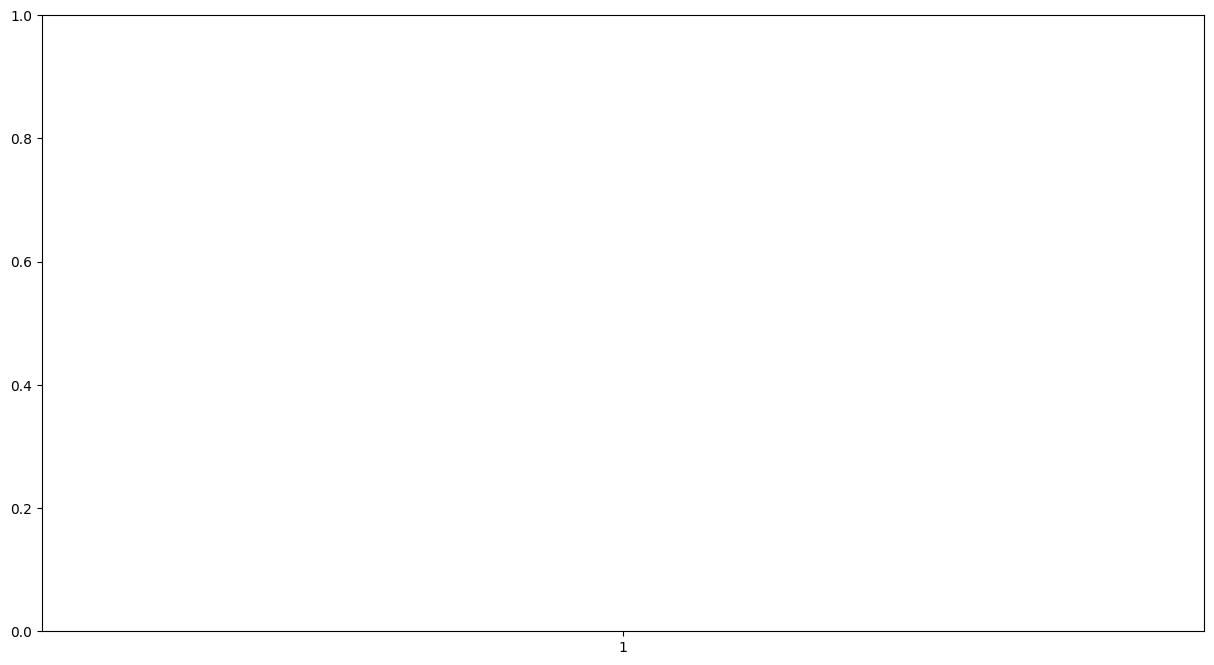

In [53]:
# Add row IDs for better readability in the bar plot
sorted_pivot_df["Row ID"] = range(1, len(sorted_pivot_df) + 1)

# Prepare the data for plotting using Row ID
plot_data = sorted_pivot_df.melt(
    id_vars=["Row ID", "Prompt Category"],
    var_name="Technique",
    value_name="Accuracy"
)

import matplotlib.pyplot as plt
import numpy as np
# Plot a bar diagram with Row ID
plt.figure(figsize=(15, 8))
for category in ["Tricky/Harmful", "Irrelevant", "Helpful"]:
    subset = plot_data[plot_data["Prompt Category"] == category]
    print(subset["Row ID"], subset["Accuracy"])
    # plt.bar(subset["Row ID"].apply(str), height=subset["Accuracy"], label=category)
    plt.bar(subset["Row ID"].apply(str), height=subset["Accuracy"].values)


plt.xticks(sorted_pivot_df["Row ID"], sorted_pivot_df["Row ID"], rotation=0, fontsize=10)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Row ID", fontsize=12)
plt.title("Promptriever Accuracy by Row ID", fontsize=14)
plt.legend(title="Prompt Category")
plt.tight_layout()

# Save and display the plot
plot_with_id_file = "./tables/promptriever_accuracy_bar_plot_with_ids.png"
plt.savefig(plot_with_id_file)
plt.show()

print(f"Bar plot with Row IDs saved to {plot_with_id_file}")
